In [1]:
%load_ext autoreload
%autoreload 1
%aimport modules.dataset_auxiliary, modules.classification_auxiliary, modules.ml_auxiliary

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import torch 
import tensorly as tl
from tensorly import random
import os
import pickle
import modules.dataset_auxiliary as daux
from modules.dataset_auxiliary import *
from modules.classification_auxiliary import *
from modules.ml_auxiliary import *
import copy


# Tensors
import tensorly as tl
from tensorly import random
from tensorly.decomposition import tucker, parafac, partial_tucker
from tensorly.tenalg import mode_dot, multi_mode_dot


# ML
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from IPython.display import clear_output

import xgboost as xgb
import pystmm


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
ls

backup/  env/  modules/  requirements.txt  tensors.ipynb  tensors_my.ipynb


## Load initial ds_dict

In [4]:
# current version
file_path = r'backup/ds_dict.pkl'

# # save:
# with open(file_path, 'wb') as f:
#     pickle.dump(ds_dict, f)

# load:
with open(file_path, 'rb') as f:
    ds_dict = pickle.load(f)

check_ds_dict(ds_dict)
print()

True 	Info: 7468;   Skeleton: 7468;   Total: 7468



## Selecting 

In [5]:
gestures = ['start', 'call', 'mute', 'pupil', 'high', 'select', 'unmute', 'close', 'yes', 'no', 'save']
# gestures = ['scroll_up', 'scroll_down', 'swipe_right', 'swipe_left', 'export'] 
# gestures = ['screenshot', 'writing', 'delete']
# gestyres = ['moving_down', 'moving_left', 'moving_right', 'moving_up', 'moving_back', 'moving_forward']
# gestures = ['anticlockwise', 'clockwise', 'right_forward', 'left_forward']
# gesture = ['zoom_in_c', 'zoom_out_c', 'zoom_out_l', 'zoom_out_r', 'zoom_in_l',  'zoom_in_r']
# gesture = ['yes_head', 'no_head']

In [6]:
# exp_cofig = "one hand gestures  | [x, y] | fill_na: {'value':0} | train: subs[0:16], test: subs[16:]"
exp_cofig = "one hand gestures  | [x, y] | fill_na: {'value':0} | train: subs[5:], test: subs[:5]"

Selected  2812 samples. 4656(7468) was dropped!
14 samples was unvalied. Ramain 2798(2812)


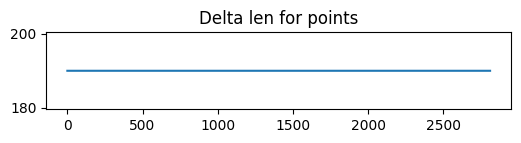

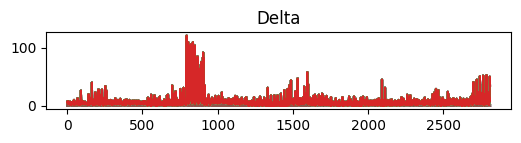

Train
Selected  2152 samples. 660(2812) was dropped!
Test
Selected  660 samples. 2152(2812) was dropped!


In [7]:
# preparing

subs = get_all_subs_from_ds_dict(ds_dict)
subs = subs[:]
gestures = ['start', 'call', 'mute', 'pupil', 'high', 'select', 'unmute', 'close', 'yes', 'no', 'save']


data_dict_selected = select_g_ids(ds_dict, subs=subs, gestures=gestures)
data_dict_valid =  select_valid_samplels(data_dict_selected)

# points
data_dict_points = select_points(data_dict_selected, coords=['x', 'y'])
plt.show()

# nan
data_dict_filled = update_skeleton(data_dict_points, update_df_fill_na, {'value':0})
plt.show()

data_dict_adjusted = update_skeleton(data_dict_filled, update_df_solve_time, show=False)


#train
print('Train')
data_dict = select_g_ids(data_dict_adjusted, subs=subs[5:])
data_dict, label_dict = form_gesture_labels(data_dict)
samples_list,  labels_list = form_samples_labels_lists(data_dict)
tensor = np.concatenate(samples_list, axis=0)

#test 
print('Test')
data_dict_test = select_g_ids(data_dict_adjusted, subs=subs[:5])
data_dict_test, label_dict_test = form_gesture_labels(data_dict_test)
samples_list_test,  labels_list_test = form_samples_labels_lists(data_dict_test)
tensor_test = np.concatenate(samples_list_test, axis=0)



### Tensor preprocessing

### CPD

In [249]:
# CPD
t = tensor
tt = tensor_test
rank = 8
factors_CPD = parafac(t, rank=rank)


In [336]:
t_rec_CPD = tl.cp_to_tensor(factors_CPD)
print(f"CPD: Rank: {rank: }, distance: {tl.norm(t - t_rec_CPD)} ; norm origin: {tl.norm(t)} ; norm recovered: {tl.norm(t_rec_CPD)}")

ValueError: too many values to unpack (expected 2)

In [308]:

factors = factors_CPD
# core = gen_diag_core_tensor(rank,len(factors.factors), factors.weights)
# classes = mode_dot(core_t, factors.factors[0], mode=0)

classes_CPD = multi_mode_dot(t, [matrix.T for matrix in factors.factors[1:]], modes=[1, 2])
classes_CPD_test = multi_mode_dot(tt, [matrix.T for matrix in factors.factors[1:]], modes=[1, 2])

### SVD

In [9]:
t = tensor
tt = tensor_test

t_uf0 = tl.unfold(t, mode=0)
u_0, s_0, v_0 = tl.partial_svd(t_uf0, )
norm_t = tl.norm(t)

rank = 600



In [18]:
len(s_0)

2152

In [20]:
def recover_svd(u_s_v, rank=None):
    u, s, v = u_s_v
    if rank is None:
        rank = len(s)
    if len(s) < rank:
        print(f"Worning! Rank [{rank}] is more then len(sigmas) [{len(s)}]!")
        rank = len(s)
        
    recover_mat = np.matmul(u[:, :rank], s[:rank])
    recover_mat = np.matmul(recover_mat, v[:rank, :])

In [ ]:
t_rec_tucker = tl.tucker_to_tensor((core_tucker, [None] + factors_tucker), skip_factor=0)
print(f"Tucker: Rank: {rank }, rel_error: {tl.norm(t - t_rec_tucker)/tl.norm(t): .5f} ; norm origin: {tl.norm(t)} ; norm recovered: {tl.norm(t_rec_tucker)}")

#### Selecting rank

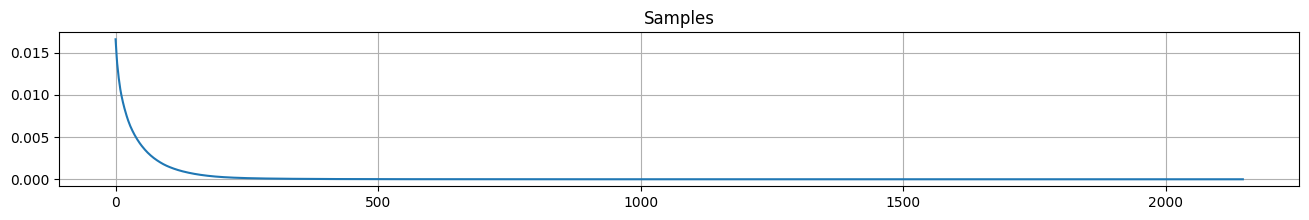

In [16]:
show_decomposition_error(s_0, norm_t,'Samples',show=False, start=5)
# plt.gcf().set_size_inches((16, 2))

### Tucker

In [21]:
t.shape

(2152, 120, 134)

In [22]:
# Tucker with HOSVD
t = tensor
tt = tensor_test
rank = [120, 134]
core_tucker, factors_tucker = partial_tucker(t, [1, 2], rank=rank, n_iter_max=1000)

# rank = [8, 60, 20]
# core_tucker, factors_tucker = tucker(t, rank=rank)


In [48]:
t_rec_tucker = tl.tucker_to_tensor((core_tucker, [None] + factors_tucker), skip_factor=0)
print(f"Tucker: Rank: {rank }, rel_error: {tl.norm(t - t_rec_tucker)/tl.norm(t): .5f} ; norm origin: {tl.norm(t)} ; norm recovered: {tl.norm(t_rec_tucker)}")

Tucker: Rank: [120, 134], rel_error:  0.00000 ; norm origin: 3721.6254553379067 ; norm recovered: 3721.625455337903


In [140]:
# # t_rec_tucker = tl.tucker_to_tensor((core_tucker, factors_tucker))
# t_rec_tucker = tl.tucker_to_tensor((core_tucker, factors_tucker))
# print(f"Tucker: Rank: {rank }, rel_error: {tl.norm(t - t_rec_tucker)/tl.norm(t): .5f} ; norm origin: {tl.norm(t)} ; norm recovered: {tl.norm(t_rec_tucker)}")

In [49]:
factors = factors_tucker
factors = [None] + factors

classes_tucker = multi_mode_dot(t, [matrix.T for matrix in factors[1:]], modes=[1, 2])
classes_tucker_test = multi_mode_dot(tt, [matrix.T for matrix in factors[1:]], modes=[1, 2])

# core = core_tucker
# classes_tucker = mode_dot(core, factors[0], mode=0)

#### Selecting ranks

In [130]:
t_uf0 = tl.unfold(t, mode=0)
t_uf1 = tl.unfold(t, mode=1)
t_uf2 = tl.unfold(t, mode=2)

In [131]:
# u_0, s_0, v_0 = tl.partial_svd(t_uf0, )
u_1, s_1, v_1 = tl.partial_svd(t_uf1, 120)
u_2, s_2, v_2 = tl.partial_svd(t_uf2, 134)

norm_t = tl.norm(t)

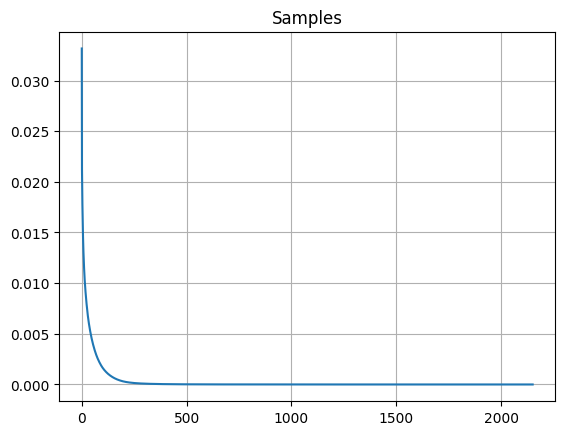

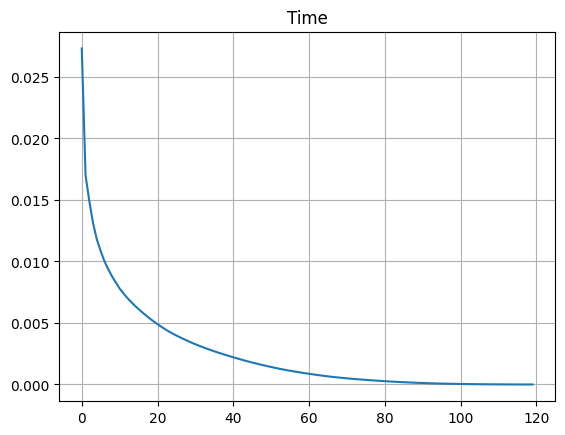

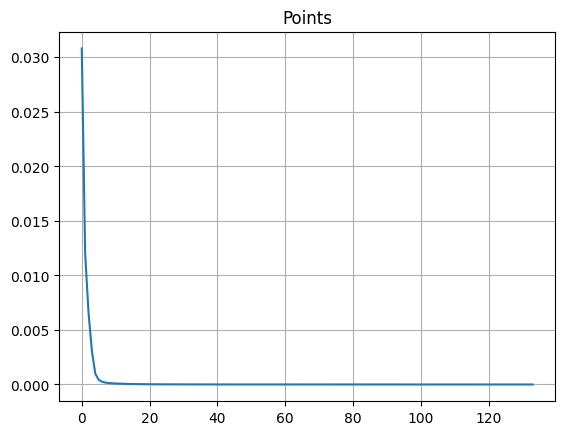

In [157]:
show_decomposition_error(s_0, norm_t,'Samples',)
show_decomposition_error(s_1, norm_t,'Time',)
show_decomposition_error(s_2, norm_t,'Points',)


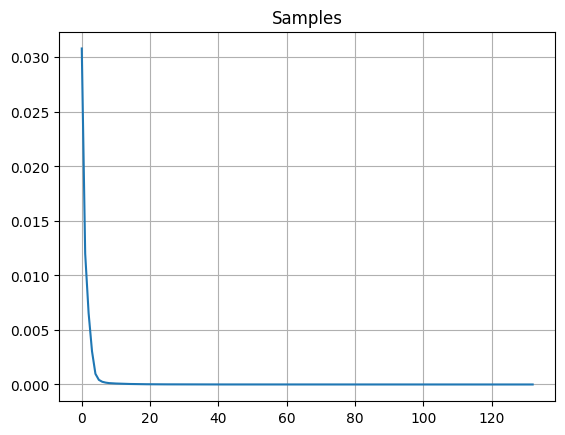

In [134]:
show_decomposition_error(s_2, norm_t,'Samples', d_step=1)

## ML part 

In [95]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from IPython.display import clear_output

import xgboost as xgb
import pystmm

In [18]:
# def apply_model(X_train, y_train, model_class, model_name, model_kwargs={}, do_scaler=False):
#     model = model_class(**model_kwargs)
#     model.fit(X_train, y_train)   

### Original

#### Support Tensor Machine

In [107]:
model = pystmm.classifier.STMM(maxIter=2, tolSTM=1e-2, tol=1e-2)
model_name = 'STMM'
X_train, y_train = make_X_y(tensor, labels_list)
X_test, y_test = make_X_y(tensor_test, labels_list_test)

X_train = tensor
X_test = tensor_test

model.fit(X_train, y_train)

maxIter  2
ovr 1.0 1.0 2 0.01 l2 True 0.01 squared_hinge 100000
1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2
1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


STMM(maxIter=2, tol=0.01, tolSTM=0.01)

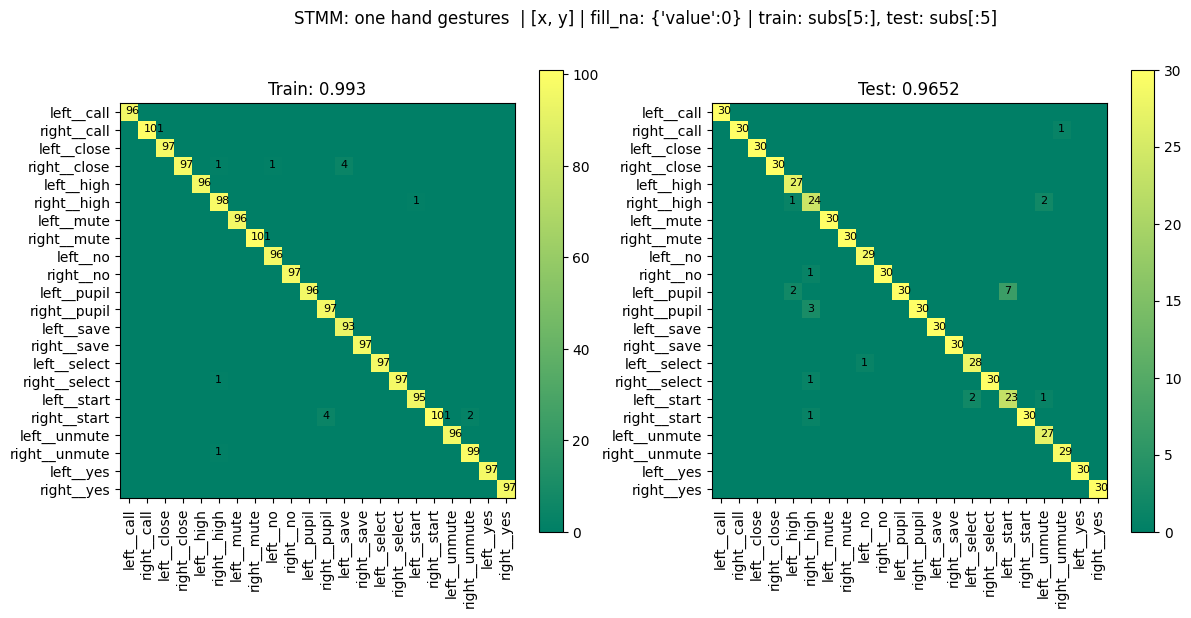

In [110]:
label_train = model.predict(X_train)
label_test = model.predict(X_test)
compare_train_test_confusion_matrices(y_train, label_train, y_test, label_test, label_dict)
plt.gcf().suptitle( model_name+ ": "+ exp_cofig)
print()

#### Others 

In [59]:
model = xgb.XGBClassifier()

model_name = 'XGB'
X_train, y_train = make_X_y(tensor, labels_list)
X_test, y_test = make_X_y(tensor_test, labels_list_test)

X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

model.fit(X_train, y_train)


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

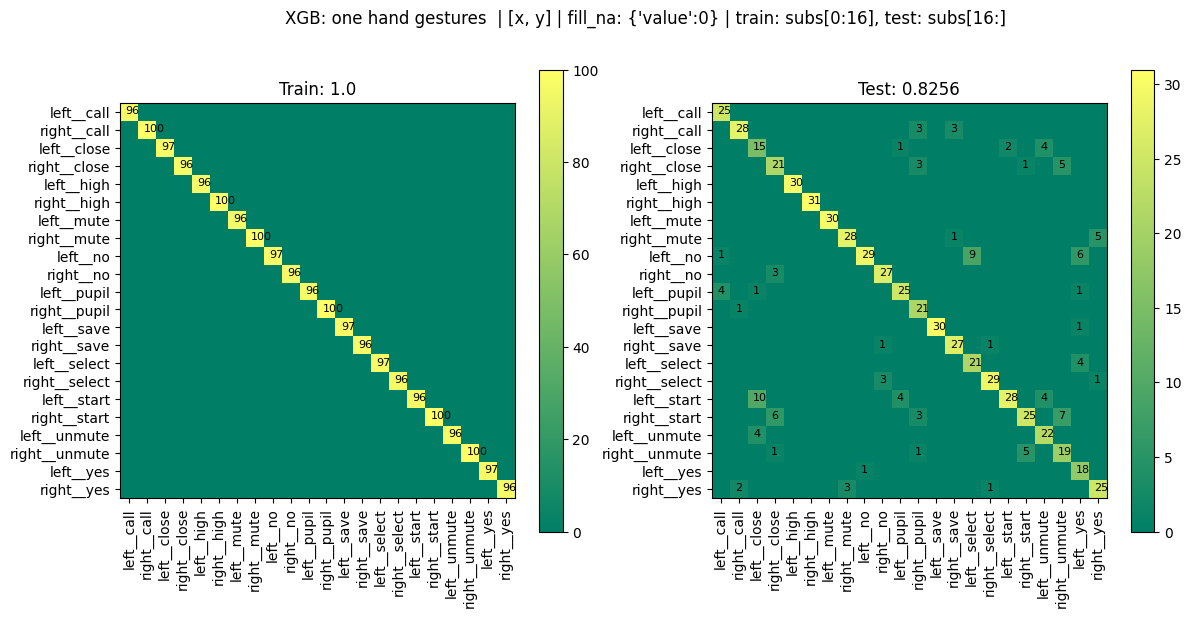

In [60]:
label_train = model.predict(X_train)
label_test = model.predict(X_test)
compare_train_test_confusion_matrices(y_train, label_train, y_test, label_test, label_dict)
plt.gcf().suptitle( model_name+ ": "+ exp_cofig)
print()

In [117]:
model = RandomForestClassifier()
model_name = 'RF'
X_train, y_train = make_X_y(tensor, labels_list)
X_test, y_test = make_X_y(tensor_test, labels_list_test)

X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

model.fit(X_train, y_train)


RandomForestClassifier()

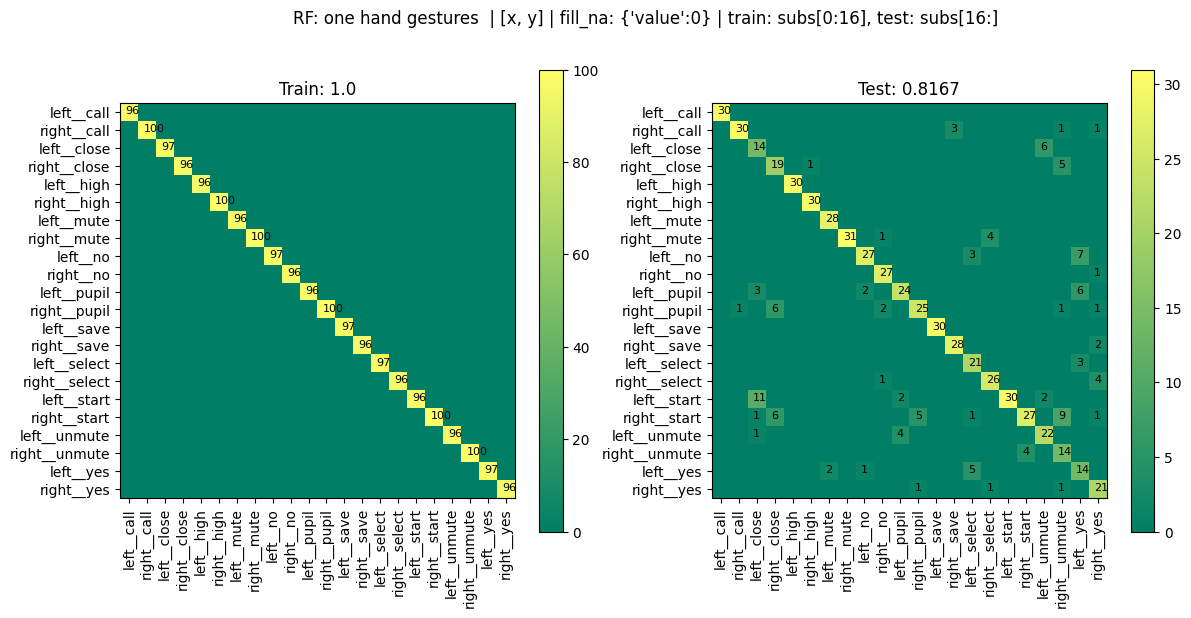

In [118]:
label_train = model.predict(X_train)
label_test = model.predict(X_test)
compare_train_test_confusion_matrices(y_train, label_train, y_test, label_test, label_dict)
plt.gcf().suptitle( model_name+ ": "+ exp_cofig)
print()

In [54]:
model = SVC(kernel='linear')
model_name = 'SVC'
X_train, y_train = make_X_y(tensor, labels_list)
X_test, y_test = make_X_y(tensor_test, labels_list_test)

X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

model.fit(X_train, y_train)

SVC(kernel='linear')

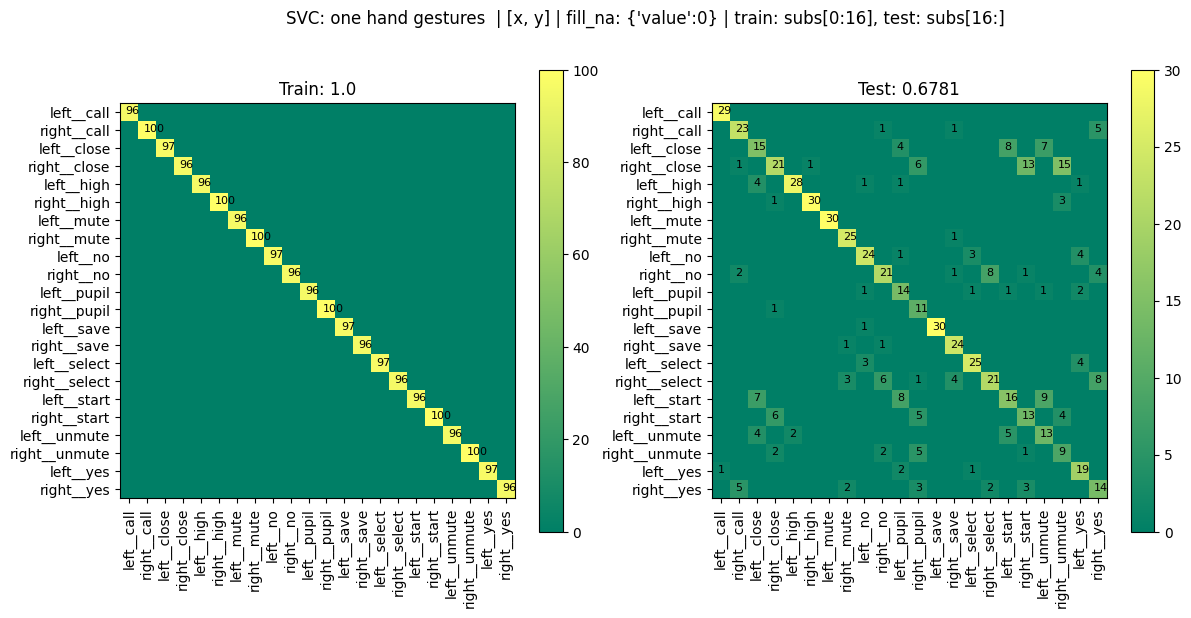

In [55]:
label_train = model.predict(X_train)
label_test = model.predict(X_test)
compare_train_test_confusion_matrices(y_train, label_train, y_test, label_test, label_dict)
plt.gcf().suptitle( model_name+ ": "+ exp_cofig)
print()

#### LogReg

In [262]:
model = LogisticRegression(max_iter=200)
model_name = 'LogReg'
X_train, y_train = make_X_y(tensor, labels_list)
X_test, y_test = make_X_y(tensor_test, labels_list_test)

X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

model.fit(X_train, y_train)

/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=200)

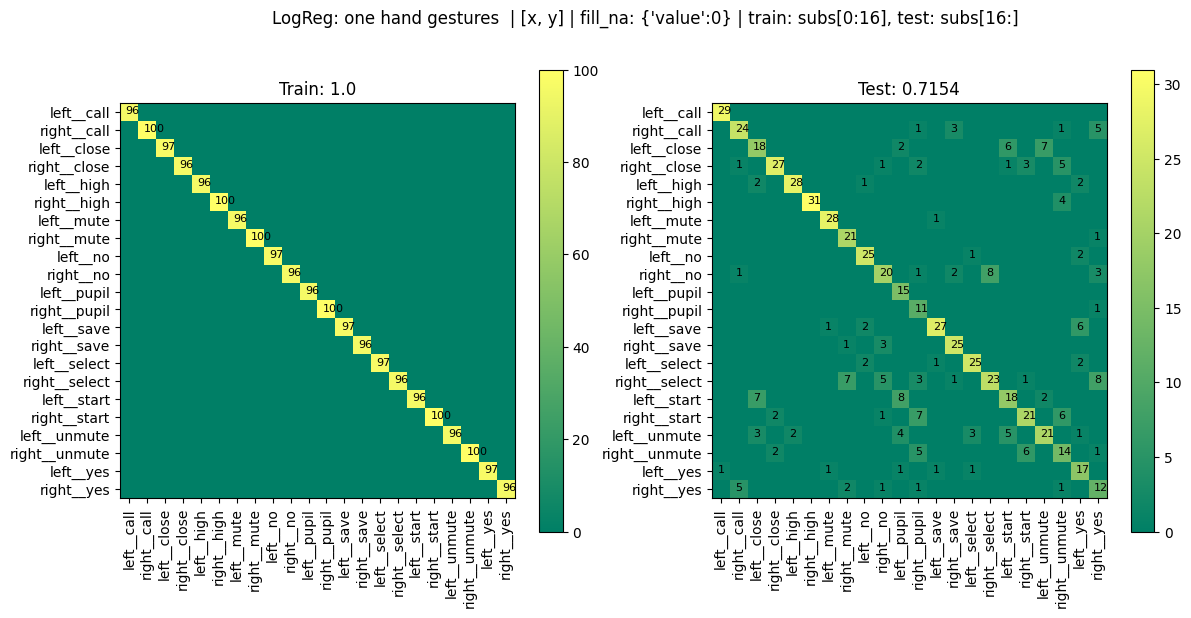

In [264]:
label_train = model.predict(X_train)
label_test = model.predict(X_test)
compare_train_test_confusion_matrices(y_train, label_train, y_test, label_test, label_dict)
plt.gcf().suptitle( model_name+ ": "+ exp_cofig)
print()


In [181]:
# label = model.predict(X_test)
# acc = accuracy_score(y_test, label )
# print(acc)
# plot_confusion_matrix(y_test, label, label_dict)
# plt.title('Confusion Matrix: Test data')

#### KNN

In [113]:
model = KNeighborsClassifier(n_neighbors=8)
model_name = 'KNN'
X_train, y_train = make_X_y(tensor, labels_list)
X_test, y_test = make_X_y(tensor_test, labels_list_test)

X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=8)

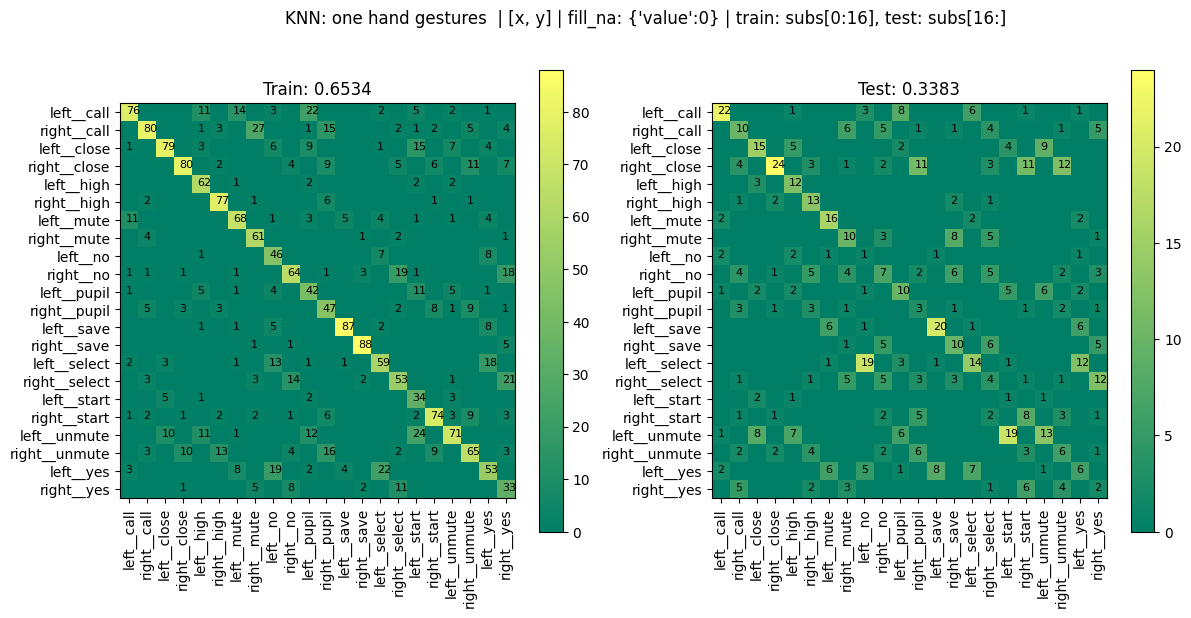

In [305]:
label_train = model.predict(X_train)
label_test = model.predict(X_test)
clear_output()
compare_train_test_confusion_matrices(y_train, label_train, y_test, label_test, label_dict)
plt.gcf().suptitle( model_name+ ": "+ exp_cofig)
print()

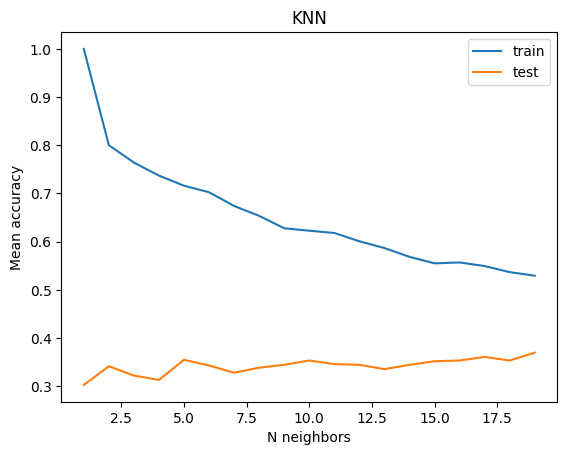

In [306]:
check_KNN(X_train, y_train, X_test, y_test, model_name)

### After CPD

In [ ]:
classes = classes_CPD
classes_test = classes_CPD_test

#### LogReg

In [271]:
model = LogisticRegression(max_iter=1000)
model_name = 'CPD + LogReg'
X_train, y_train = make_X_y(classes, labels_list)
X_test, y_test = make_X_y(classes_test, labels_list_test)

# X_train = StandardScaler().fit_transform(X_train)
# X_test = StandardScaler().fit_transform(X_test)

model.fit(X_train, y_train)

/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)

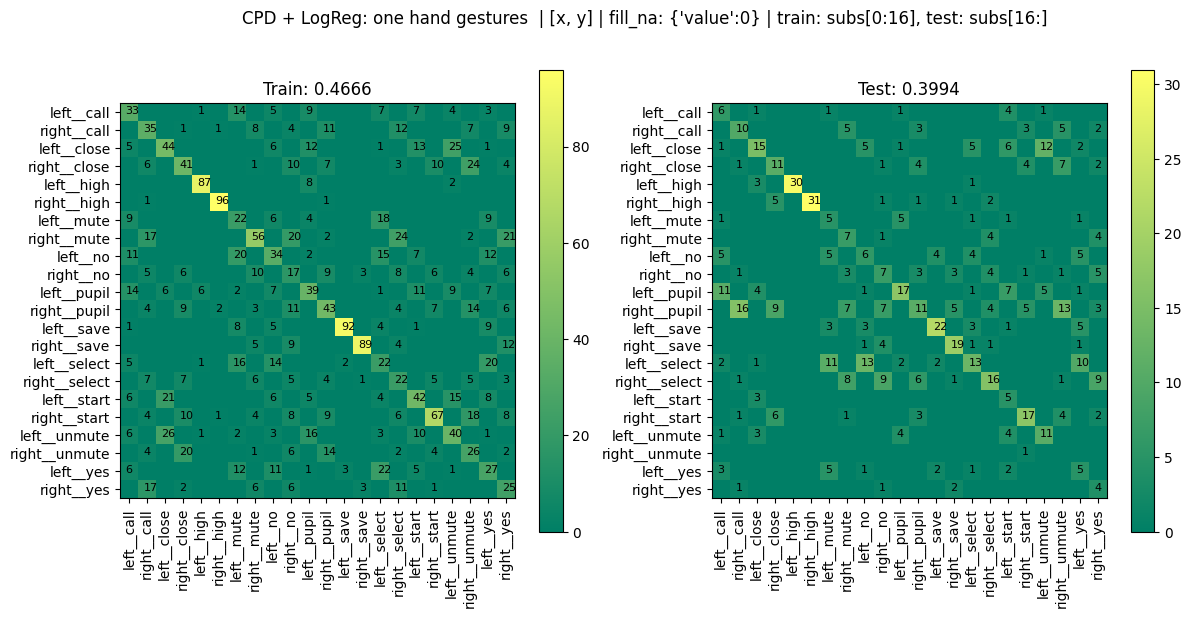

In [272]:
label_train = model.predict(X_train)
label_test = model.predict(X_test)
clear_output()
compare_train_test_confusion_matrices(y_train, label_train, y_test, label_test, label_dict)
plt.gcf().suptitle( model_name+ ": "+ exp_cofig)
print()

#### KNN

In [302]:
model = KNeighborsClassifier(n_neighbors=14)
model_name = 'CPD + KNN'
X_train, y_train = make_X_y(classes, labels_list)
X_test, y_test = make_X_y(classes_test, labels_list_test)

# X_train = StandardScaler().fit_transform(X_train)
# X_test = StandardScaler().fit_transform(X_test)

model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=14)

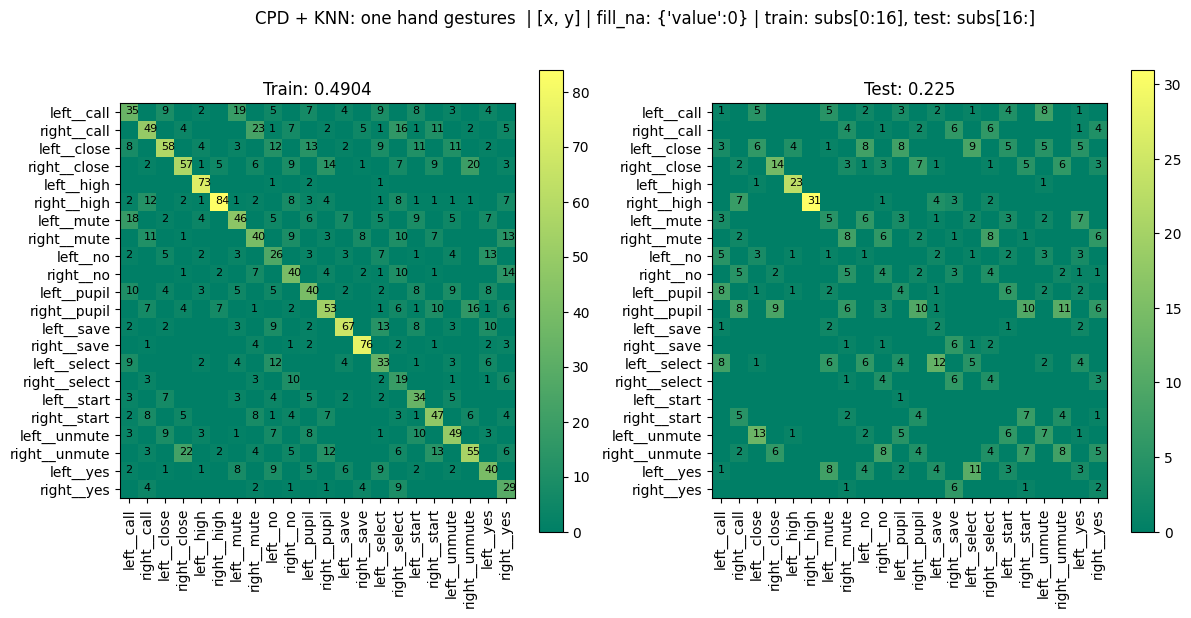

In [303]:
label_train = model.predict(X_train)
label_test = model.predict(X_test)
clear_output()
compare_train_test_confusion_matrices(y_train, label_train, y_test, label_test, label_dict)
plt.gcf().suptitle( model_name+ ": "+ exp_cofig)
print()

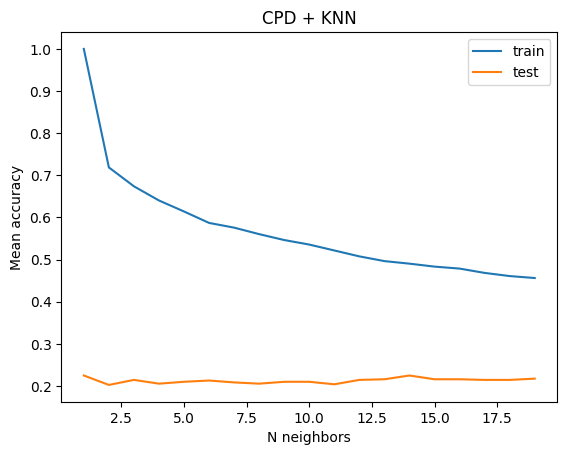

In [296]:
check_KNN(X_train, y_train, X_test, y_test, model_name)  

### After Tucker

In [28]:
classes = classes_tucker
classes_test = classes_tucker_test

In [98]:
t.shape

(2152, 120, 134)

#### STM

In [42]:
model = pystmm.classifier.STMM(maxIter=2, tolSTM=1e-2, tol=1e-2)
model_name = 'Tucker + STMM'
X_train, y_train = make_X_y(classes, labels_list)
X_test, y_test = make_X_y(classes_test, labels_list_test)

X_train = classes_tucker
X_test = classes_test

model.fit(X_train, y_train)


maxIter  2
ovr 1.0 1.0 2 0.01 l2 True 0.01 squared_hinge 100000
1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2
1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2
1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2
1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2
1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2
1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2
1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2
1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2
1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2
1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2
1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2
1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2
1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2
1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2
1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2
1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2
1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2
1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2
1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


STMM(maxIter=2, tol=0.01, tolSTM=0.01)

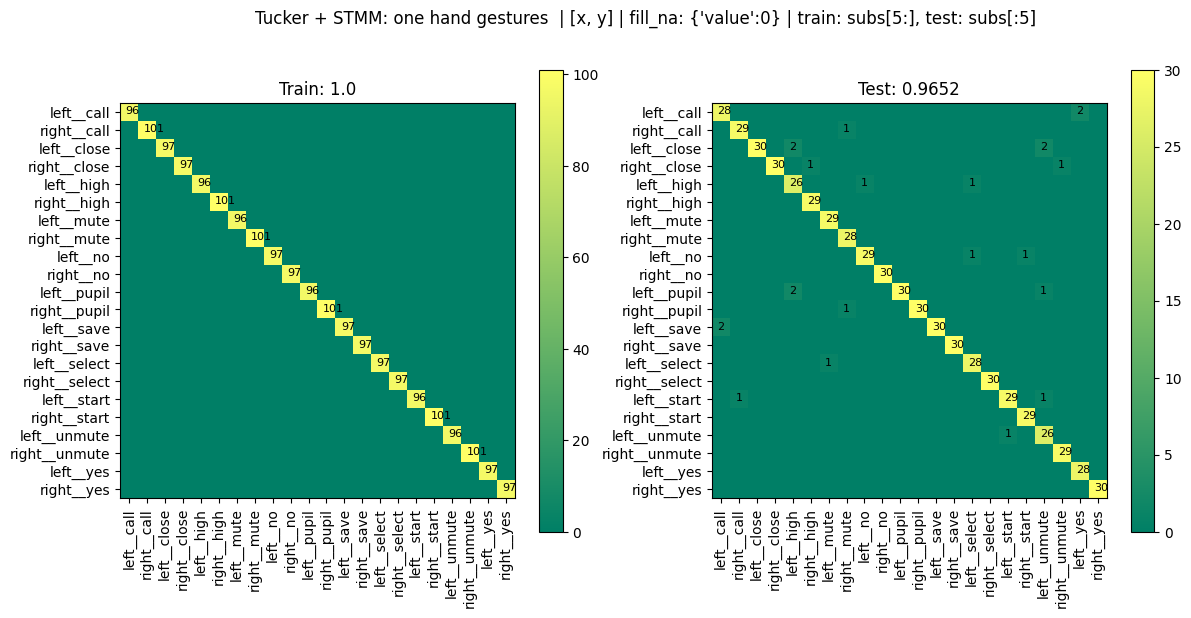

In [56]:
label_train = model.predict(X_train)
label_test = model.predict(X_test)
compare_train_test_confusion_matrices(y_train, label_train, y_test, label_test, label_dict)
plt.gcf().suptitle( model_name + ": "+ exp_cofig)
print()

#### other

In [44]:
model = xgb.XGBClassifier(n_estimators=200, max_depth=6)

model_name = 'Tucker + XGB'
X_train, y_train = make_X_y(classes, labels_list)
X_test, y_test = make_X_y(classes_test, labels_list_test)

X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

model.fit(X_train, y_train)


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=200,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

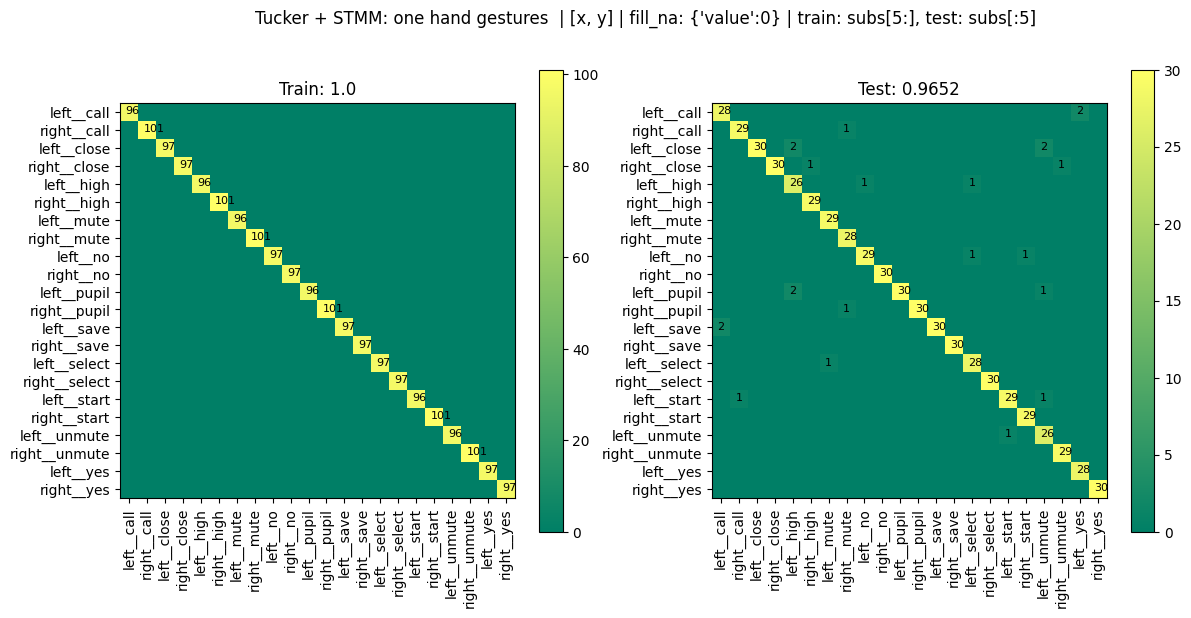

In [57]:
label_train = model.predict(X_train)
label_test = model.predict(X_test)
compare_train_test_confusion_matrices(y_train, label_train, y_test, label_test, label_dict)
plt.gcf().suptitle( model_name+ ": "+ exp_cofig)
print()

In [36]:
model = RandomForestClassifier(n_estimators=200, max_depth=20)
model_name = 'Tucker + RF'
X_train, y_train = make_X_y(classes, labels_list)
X_test, y_test = make_X_y(classes_test, labels_list_test)

X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

model.fit(X_train, y_train)


RandomForestClassifier(max_depth=20, n_estimators=200)

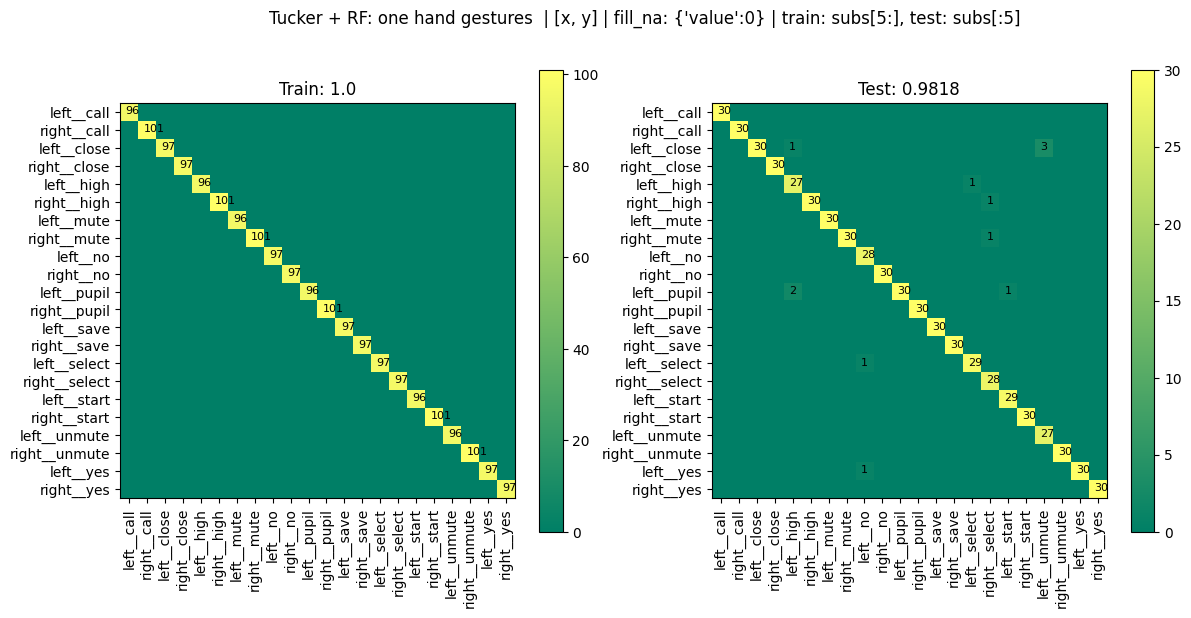

In [37]:
label_train = model.predict(X_train)
label_test = model.predict(X_test)
compare_train_test_confusion_matrices(y_train, label_train, y_test, label_test, label_dict)
plt.gcf().suptitle( model_name+ ": "+ exp_cofig)
print()

In [38]:
model = SVC(C=1, kernel='linear')
model_name = 'Tucker + SVC'
X_train, y_train = make_X_y(classes, labels_list)
X_test, y_test = make_X_y(classes_test, labels_list_test)

X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

model.fit(X_train, y_train)

SVC(C=1, kernel='linear')

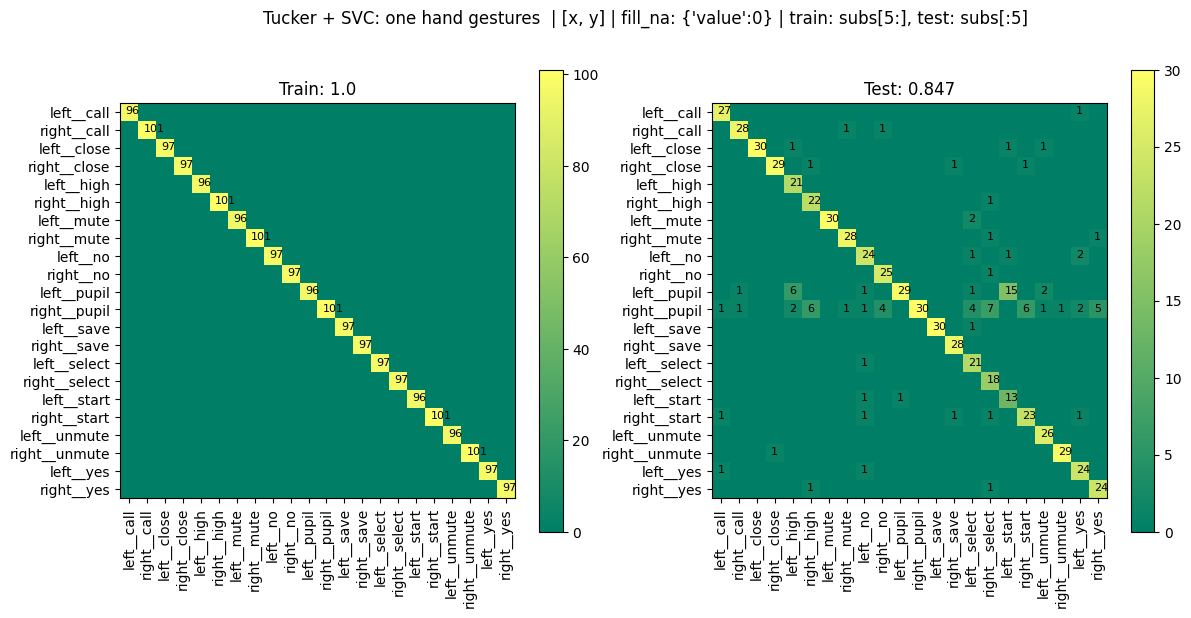

In [39]:
label_train = model.predict(X_train)
label_test = model.predict(X_test)
compare_train_test_confusion_matrices(y_train, label_train, y_test, label_test, label_dict)
plt.gcf().suptitle( model_name+ ": "+ exp_cofig)
print()

#### LogReg

In [29]:
model = LogisticRegression(max_iter=1000)
model_name = 'Partial_Tucker + LogReg'
X_train, y_train = make_X_y(classes, labels_list)
X_test, y_test = make_X_y(classes_test, labels_list_test)

# X_train = StandardScaler().fit_transform(X_train)
# X_test = StandardScaler().fit_transform(X_test)

model.fit(X_train, y_train)

/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)

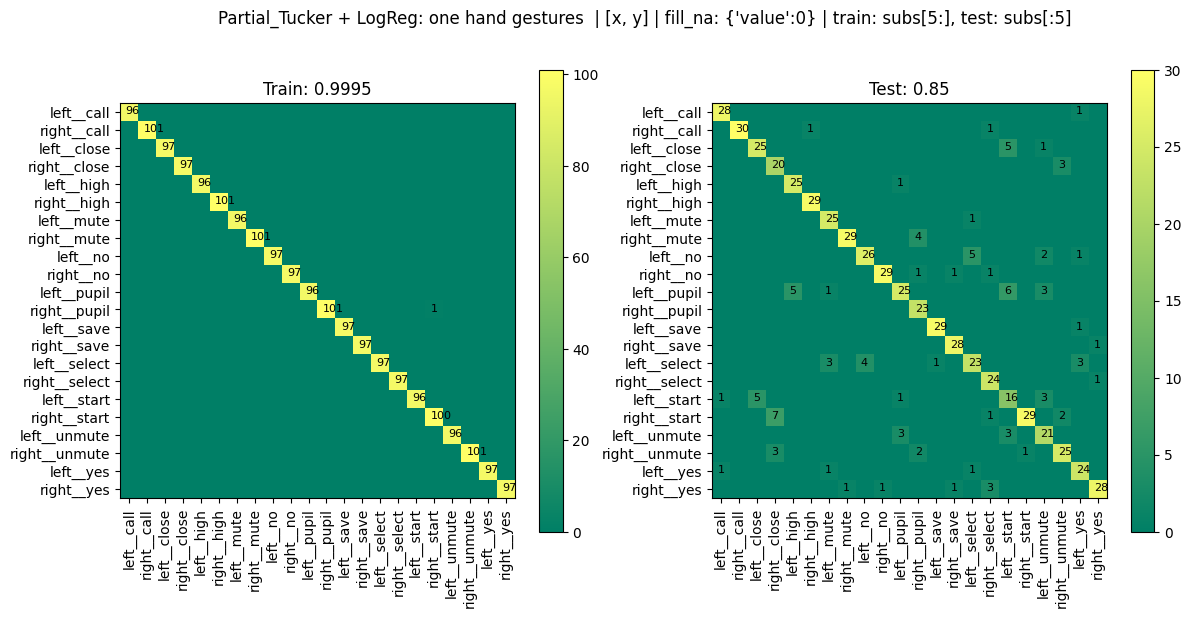

In [30]:
label_train = model.predict(X_train)
label_test = model.predict(X_test)
clear_output()
compare_train_test_confusion_matrices(y_train, label_train, y_test, label_test, label_dict)
plt.gcf().suptitle( model_name+ ": "+ exp_cofig)
print()

#### KNN

In [31]:
model = KNeighborsClassifier(n_neighbors=30)
model_name = 'Tucker+ KNN'
X_train, y_train = make_X_y(classes, labels_list)
X_test, y_test = make_X_y(classes_test, labels_list_test)

# X_train = StandardScaler().fit_transform(X_train)
# X_test = StandardScaler().fit_transform(X_test)

model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=30)

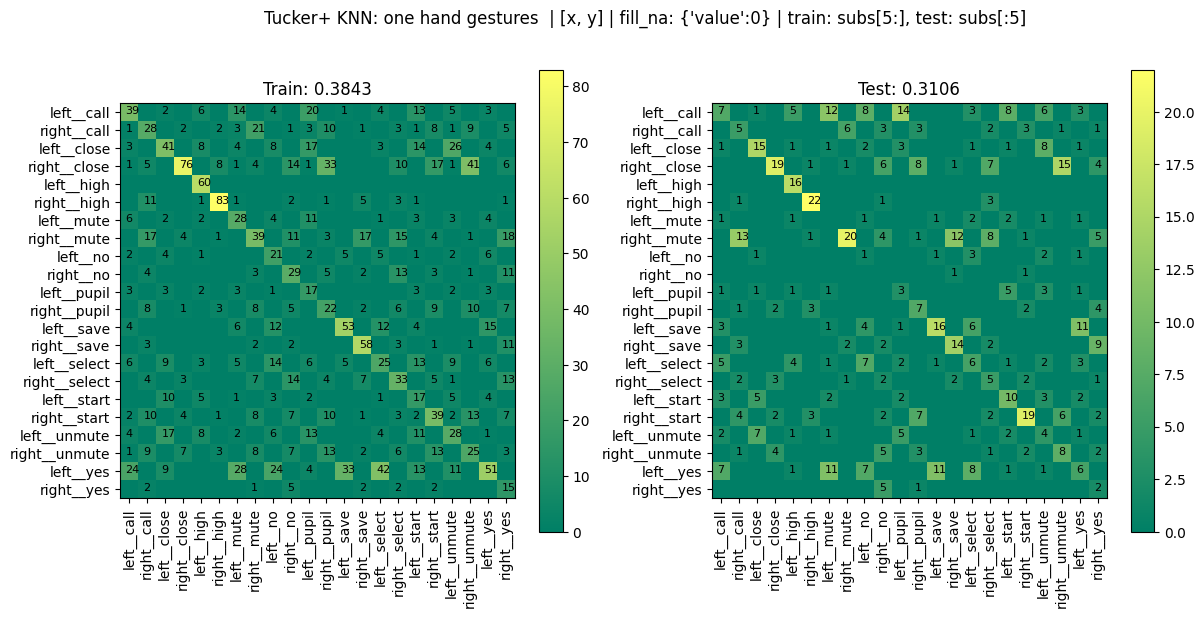

In [32]:
label_train = model.predict(X_train)
label_test = model.predict(X_test)
clear_output()
compare_train_test_confusion_matrices(y_train, label_train, y_test, label_test, label_dict)
plt.gcf().suptitle( model_name+ ": "+ exp_cofig)
print()

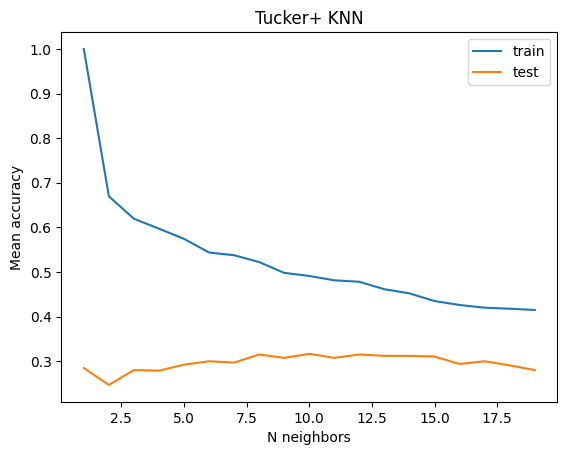

In [33]:
check_KNN(X_train, y_train, X_test, y_test, model_name)  